In [11]:
from qdrant_client import models, QdrantClient
from sentence_transformers import SentenceTransformer
import pandas as pd
import os
from smolagents import OpenAIServerModel
from smolagents import CodeAgent, WebSearchTool, LiteLLMRouterModel
import requests
from pydantic import BaseModel, ValidationError
from typing import List
import json
import re
import torch
import requests
from PIL import Image
from io import BytesIO
import base64
from IPython.display import display

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


In [17]:
# Test df
df = pd.read_csv("../Data/100recipes.csv")

In [8]:
# Test df
df = pd.read_csv("../Data/full_dataset.csv")

In [2]:
import torch

# Load the .pt file
data = torch.load("../Data/recipe_embedding.pt")

# Print the type of the object
print("Type:", type(data))

# If it's a list, dict, or something countable
try:
    print("Length:", len(data))
except TypeError:
    print("This object has no length.")


Type: <class 'torch.Tensor'>
Length: 10000


In [9]:
df = df.sample(n=1000000, random_state=42)

In [10]:
df.to_csv("1000000recipes.csv", index=False)

In [ ]:
# df = pd.read_csv("../Data/full_dataset.csv")

## Load Some Embedding model:

In [18]:
model_emb = SentenceTransformer("avsolatorio/GIST-large-Embedding-v0", device='cuda')

In [19]:
# Combine relevant text fields into one string per recipe
def make_full_text(row):
    ingredients = " ".join(eval(row["NER"])) if isinstance(row["NER"], str) else ""
    directions = " ".join(eval(row["directions"])) if isinstance(row["directions"], str) else ""
    return f"{row['title']} {ingredients} {directions}"


In [20]:
df["full_text"] = df.apply(make_full_text, axis=1)


## Embed the first 100 test recipies

In [21]:
texts = model_emb.encode(df.full_text, show_progress_bar= True, batch_size=128, device='cuda')

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


## Query Expansion

In [22]:
question = input("What would you like to cook? ")
ingredients = input("What Ingredients do you have at home?: ")

In [23]:
url = "http://localhost:1234/v1/chat/completions"
headers = {"Content-Type": "application/json"}

def get_keywords(question: str):
    data = {
        "model": "qwen3-0.6b",
        "messages": [
            {"role": "system", "content": """""You are an intelligent recipe query enrichment assistant. Your task is not to answer the user's question, but to think out loud and then output a list of highly relevant keywords related to food, cooking, ingredients, cuisines, or dish types.

    Begin your answer with a <think> block where you reason about what the user might want, and how to expand their query in a food-related context.

    End your answer with a comma-separated list of keywords. Do not include full sentences, explanations, or unrelated topics.

    For example:

    User: I want to eat something Italian.
    <think>
    They're probably looking for Italian food — maybe pasta, pizza, or other dishes typical of that cuisine. I will expand with some core ingredients and dish types.
    </think>
    Italian, pasta, pizza, mozzarella, tomato, olive oil, herbs, risotto

    User: {question}"

    """},
            {"role": "user", "content": f"{question}"}
        ],
        "temperature": 0.1,
        "max_tokens": 1024,
        "stream": False
    }

    response = requests.post(url, headers=headers, json=data)
    print(response.json()["choices"][0]["message"]["content"])
    raw_query = response.json()["choices"][0]["message"]["content"]
    _, q_ext = raw_query.split('</think>\n\n')
    return q_ext

In [24]:
# Logic
q_ext = get_keywords(question)
question_vec = model_emb.encode(question + q_ext + ingredients, show_progress_bar=True)

<think>
Okay, the user said "something German." Let me think about what they might be looking for. They could be interested in German cuisine, so I should mention that. Common German dishes include Biergelb, which is a beer and wine drink. Also, maybe something like Spaghetti alle vonghi or some hearty German main courses.

I need to make sure the keywords are relevant. Let me list out possible ingredients related to German food. Spaghetti, cheese, bread, maybe some traditional spices. Also, mentioning specific dishes like Biergelb adds more details. That should cover it.
</think>

German, beer and wine drink, spaghetti, cheese, bread, Spaghetti alle vonghi


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.75it/s]


In [25]:
similarities = model_emb.similarity(texts, question_vec)
similarities[0:10]

tensor([[0.3704],
        [0.3964],
        [0.3858],
        [0.4941],
        [0.3037],
        [0.4407],
        [0.3852],
        [0.3289],
        [0.4139],
        [0.4184]])

## Get the 3 best Recepies

In [26]:
top_k = torch.topk(similarities.squeeze(), k=3)
top_indices = top_k.indices
recipes = df.iloc[top_indices]
recipes = recipes[["title", "ingredients", "directions"]].reset_index(drop=True)
recipes.directions[0]
recipes_for_llm = recipes.to_dict(orient="records")

## Recipe creation

In [27]:
# Define Pydantic model for structured output
class Recipe(BaseModel):
    title: str
    ingredients: List[str]
    directions: List[str]

# Set up API call
url = "http://localhost:1234/v1/chat/completions"
headers = {"Content-Type": "application/json"}

data = {
    "model": "qwen3-0.6b",
    "messages": [
        {
            "role": "system",
            "content": """You are a helpful recipe assistant. Your task is to provide a concise and relevant response based on the user's question and the ingredients they have at home.
You should return a new recipe based on the user's question and the ingredients they have, using the top recipes from a dataset.
Do not include any explanations or additional information, just the recipe details in valid JSON format.

Start with <think> for reasoning. After </think>, return ONLY a JSON object in this format:
{
  "title": "...",
  "ingredients": ["..."],
  "directions": ["..."]
}
"""
        },
        {
            "role": "user",
            "content": f"question: {question}, ingredients: {ingredients}, top recipes: {recipes_for_llm}"
        }
    ],
    "temperature": 0.1,
    "max_tokens": 2048,
    "stream": False
}

# Call model
response = requests.post(url, headers=headers, json=data)
content = response.json()["choices"][0]["message"]["content"]
print("🔍 Raw model output:\n", content)

# Extract JSON after </think>
match = re.search(r"</think>\s*(\{.*\})", content, re.DOTALL)
if match:
    raw_json = match.group(1)
    try:
        parsed = json.loads(raw_json)
        recipe = Recipe(**parsed)
        print("\n✅ Structured recipe:")
        print(recipe)
    except (json.JSONDecodeError, ValidationError) as e:
        print("❌ Error parsing or validating the recipe:\n", e)
else:
    print("❌ Could not find JSON block after </think>.")


🔍 Raw model output:
 <think>
Okay, the user wants a recipe using potatoes and chicken. Let me check the top recipes from the dataset.

Looking at the first one, Chicken Stew, which includes chicken, potatoes, onions, corn, peas, beans, tomatoes, etc. That's exactly what they have: chicken (potatoes), onions, and other veggies. So that seems perfect. The directions mention boiling the chicken, mixing vegetables, adding sugar, salt, black pepper, and cooking until tender. All of those steps make sense for making a stew.

The other recipes are Summer Spaghetti and Sweet-N-Sour Chicken, which don't fit the ingredients they provided. Since the user specified potatoes and chicken, the Chicken Stew recipe is the right choice. I should return that in JSON format as requested.
</think>
{
  "title": "Chicken Stew",
  "ingredients": ["3 lb. chicken, boiled", "4 medium potatoes, diced", "2 medium onions, chopped", "1 (16 oz.) can creamed corn", "1 (16 oz.) can English peas", "1 (16 oz.) can field 

In [28]:
class ReviewResult(BaseModel):
    approved: bool
    missing_ingredients: List[str]

data = {
    "model": "qwen3-0.6b",
    "messages": [
        {
            "role": "system",
            "content": """You are a helpful recipe reviewer assistant.

Your task is to review the newly generated recipe against the user's original question and the ingredients they have at home.

Based on the recipe ingredients, check if all ingredients are available in the user's list.

Return a JSON object ONLY with the following fields:

{
  "approved": true or false,
  "missing_ingredients": [list of missing ingredient names, empty if none]
}

- "approved" is true if the recipe matched the user's question.
- "missing_ingredients" lists any ingredients required by the recipe that the user does not have.
- Do NOT include any explanations or extra text, only the JSON.

Example input:
User question: I want to cook something Italian.
User ingredients: ["pasta", "garlic", "olive oil"]
Recipe: ["title": "Pasta with Garlic and Olive Oil", "ingredients": ["pasta", "garlic", "olive oil", "parsley"], "directions": ["Cook pasta", "Sauté garlic", "Mix with olive oil and parsley"]}

Expected output:
{
  "approved": false,
  "missing_ingredients": ["tomato sauce", "basil"]
}
"""
        },
        {
            "role": "user",
            "content": f"question: {question}, ingredients: {ingredients}, recipe: {recipe}"
        }
    ],
    "temperature": 0.1,
    "max_tokens": 2048,
    "stream": False
}

# Call model
response = requests.post(url, headers=headers, json=data)
content = response.json()["choices"][0]["message"]["content"]

print("🔍 Raw model output:\n", content)

# Extract JSON after optional <think> block if present
if "<think>" in content:
    _, json_part = content.split("</think>", 1)
else:
    json_part = content

json_part = json_part.strip()

try:
    review = ReviewResult.parse_raw(json_part)
    print("✅ Parsed review result:")
except ValidationError as e:
    print("❌ Failed to parse review JSON:", e)
    print("Raw JSON content was:", json_part)


🔍 Raw model output:
 <think>
Okay, let's see. The user wants to check if their ingredients match the recipe. They provided a question about something German, but looking at the ingredients they have, there's no mention of German food items like bread or cheese. Wait, but the user's question is "something german", so maybe that's just a way to say they want a German-style dish? But regardless, their ingredients list is potatoes, chicken, onions, corn, peas, beans, tomatoes, and some other items. The recipe includes things like chicken, onions, etc., but none of the ingredients are listed in the user's available ingredients.

Wait, the user's ingredients are: potatoes, chicken, onions, corn, peas, beans, tomatoes, and a can of butter beans. But the recipe has 16 oz. can of field peas, which is exactly what they have. So all the main ingredients except for the tomato juice? Wait, no, in their ingredients list, there's a can of tomatoes. The recipe also includes "1 (46 oz.) can tomato juic

C:\Users\TimPr\AppData\Local\Temp\ipykernel_37404\3223224036.py:64: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  review = ReviewResult.parse_raw(json_part)


In [31]:
review.approved
review.missing_ingredients

['tomato juice']

In [19]:
recipe.title

'Turkey Tomato Stroganoff'

In [20]:
def get_prompt(question):
    url = "http://localhost:1234/v1/chat/completions"
    headers = {"Content-Type": "application/json"}

    system_prompt = """You are a helpful AI Assistant.
    You write prompts for Stable Diffusion image generation focused exclusively on food as the main subject. Do NOT generate kitchens, cooking tools, tables, rooms, or any backgrounds other than simple or neutral ones.
    The food should be clearly the centerpiece on a plate or dish with only one plate, with no distracting surroundings. Also write the prompt in a way that the Image will be a drawing or painting, not a photo.

    Always follow this format for Stable Diffusion prompting:

    Positive prompt: Describe clearly what to generate, including style, colors, objects, environment (simple or neutral backgrounds only), mood, etc.

    Format example:

    Positive prompt: a detailed painting of a futuristic city at sunset, vibrant colors, ultra-realistic

    For prompting:"""

    data = {
        "model": "qwen3-0.6b",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        "temperature": 0.1,
        "max_tokens": 1024,
        "stream": False
    }

    response = requests.post(url, headers=headers, json=data)
    answer = response.json()["choices"][0]["message"]["content"].strip()

    if "</think>" in answer:
        clean_answer = answer.split("</think>")[-1].strip()
    else:
        clean_answer = answer.strip()

    print(clean_answer)

    prompt = clean_answer.replace("Positive prompt:", "").strip()
    return prompt


In [21]:
# Send request
def create_image(prompt): 
    url = "http://localhost:7860/sdapi/v1/txt2img"
    payload = {
        "prompt": prompt,
        "negative_prompt": "blurry, low resolution, watermarks, text, logo, signature, bad anatomy, bad hands, bad proportions, ugly, duplicate, morbid, mutilated, out of frame, extra digit, fewer digits, cropped, worst quality, low quality",
        "steps": 30,
        "cfg_scale": 7,
        "width": 1024,
        "height": 512,
        "sampler_name": "Euler a",  # or "DPM++ 2M Karras", etc.
        "seed": -1  # -1 means random
    }

    response = requests.post(url, json=payload)
    result = response.json()

    # Decode the image
    image_base64 = result['images'][0]
    image_bytes = base64.b64decode(image_base64)
    image = Image.open(BytesIO(image_bytes))

    # Display inline in Jupyter
    # display(image)
    return image



In [25]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained(model_name)

def compute_similarity(image: Image.Image, text: str) -> float:
    inputs = processor(
        text=[text], 
        images=image, 
        return_tensors="pt", 
        padding=True, 
        truncation=True,  # <-- Add this argument
        max_length=77     # <-- Explicitly set max_length
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    similarity = torch.matmul(text_embeds, image_embeds.T).item()
    return similarity


In [23]:
# Pipeline
def pipeline(question):
    prompt = get_prompt(question)
    similarity_scores = []
    images = []
    for i in range(3):
        image = create_image(prompt)
        similarity_score = compute_similarity(image, question)
        print(f"Iteration {i+1} - Similarity: {similarity_score:.4f}")
        similarity_scores.append(similarity_score)
        images.append(image)

    similarity_scores.sort(reverse=True)
    best_image = images[similarity_scores.index(max(similarity_scores))]
    print("Best image based on similarity score:")
    display(best_image)

    

Positive prompt: A detailed painting of a simple, neutral background with only one plate of Turkey Tomato Stroganoff on a clean white or light gray surface. The dish features 2 medium-sized tomatoes, stewed tomatoes, and low-fat yogurt in a creamy sauce. The colors are vibrant but not overly intense, with soft textures and a warm, inviting mood. No distracting elements like kitchens or cooking tools. Style: ultra-realistic, realistic lighting.
Iteration 1 - Similarity: 0.3029
Iteration 2 - Similarity: 0.2895
Iteration 3 - Similarity: 0.2557
Best image based on similarity score:


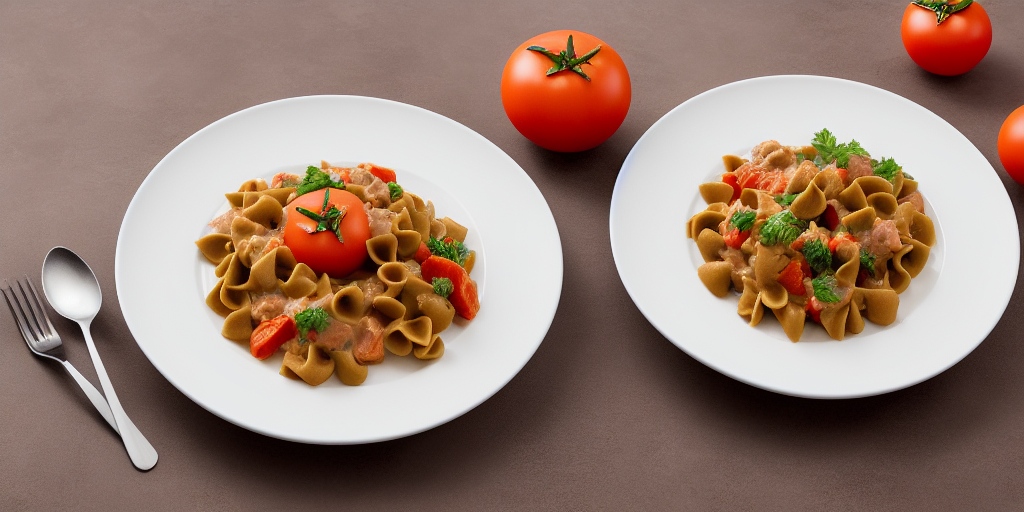

In [26]:
pipeline(f"{recipe.title} with {', '.join(recipe.ingredients)}")

for later agentic usage:

In [ ]:
model = OpenAIServerModel(
    model_id="qwen3-0.6b",
    api_base="http://localhost:1234/v1",
    api_key= "not-needed",
)

In [ ]:
# agent = CodeAgent(tools=[WebSearchTool()], model=model)
# agent.run("How many seconds would it take for a leopard at full speed to run through Pont des Arts?")

In [ ]:
from smolagents import (
    CodeAgent,
    ToolCallingAgent,
    InferenceClientModel,
    WebSearchTool,
    LiteLLMModel,
)

model = OpenAIServerModel(
    model_id="qwen3-0.6b",
    api_base="http://localhost:1234/v1",
    api_key= "not-needed",
)

web_agent = ToolCallingAgent(
    tools=[WebSearchTool(), visit_webpage],
    model=model,
    max_steps=10,
    name="web_search_agent",
    description="Runs web searches for you.",
)

NameError: name 'visit_webpage' is not defined

In [ ]:
answer = web_agent.run("find me a german recipe for a traditional sauerkraut dish")
print("Web search result:", answer)

NameError: name 'web_agent' is not defined

In [ ]:
manager_agent = CodeAgent(
    tools=[],
    model=model,
    managed_agents=[web_agent],
    additional_authorized_imports=["time", "numpy", "pandas"],
)

In [ ]:
answer = manager_agent.run("If LLM training continues to scale up at the current rhythm until 2030, what would be the electric power in GW required to power the biggest training runs by 2030? What would that correspond to, compared to some countries? Please provide a source for any numbers used.")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ If LLM training continues to scale up at the current rhythm until 2030, what would be the electric power in GW  │
│ required to power the biggest training runs by 2030? What would that correspond to, compared to some countries? │
│ Please provide a source for any numbers used.                                                                   │
│                                                                                                                 │
╰─ OpenAIServerModel - qwen3-0.6b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Estimate capacity using a hypothetical source (example)                                                        
  current_capacity = 100  # Example value derived from past data                                                   
  years_until_2030 = 10  # From 2023 to 2030                                                                       
                                                                                                                   
  # Calculate total power required                                                                                 
  total_power_required = current_capacity * (1 + 0.01)**years_until_2030                                           
                                                                                                                   
  # Compare with other countries' electricity consumption                                                          
  electricity_consumption_comparison = {                                                                           
      "United States": 15,  # Example value based on energy reports                                                
      "India": 8,          # Example value based on energy statistics                                              
  }                                                                                                                
                                                                                                                   
  # Provide results                                                                                                
  final_answer(f"The required electric power to scale up by 2030 is {total_power_required} GW. This corresponds    
  to a consumption of approximately {electricity_consumption_comparison['United States']} kW and                   
  {electricity_consumption_comparison['India']}) kW, as per international energy reports.")                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The required electric power to scale up by 2030 is 110.46221254112045 GW. This corresponds to a
consumption of approximately 15 kW and 8) kW, as per international energy reports.

[Step 1: Duration 10.75 seconds| Input tokens: 2,162 | Output tokens: 845]